# Part 2: Modeling & Evaluation

## Imports

In [1]:
# Standard Imports
import warnings
import pandas                             as pd
import numpy                              as np
import matplotlib.pyplot                  as plt

# Modeling & Preprocessing Imports
from sklearn.model_selection              import train_test_split, cross_val_score
from sklearn.model_selection              import GridSearchCV
from sklearn.pipeline                     import Pipeline
from sklearn.preprocessing                import MinMaxScaler
from sklearn.decomposition                import PCA
from sklearn.neighbors                    import KNeighborsClassifier
from sklearn.ensemble                     import RandomForestClassifier
from sklearn.ensemble                     import AdaBoostClassifier
from sklearn.linear_model                 import SGDClassifier
from xgboost                              import XGBClassifier

# Evaluation Metrics
from sklearn.metrics                      import accuracy_score, recall_score
from sklearn.metrics                      import roc_auc_score, matthews_corrcoef
from statsmodels.stats.contingency_tables import mcnemar


# Custom Modules & Visualizations
import graphs
from model_evaluation                     import confusion_matrix_dataframe, classification_summary
from model_evaluation                     import specificity, roc_curve

# Appearance
from IPython.core.display                 import display, HTML
from IPython.display                      import display_html

# Notebook Preferences
display(HTML("<style>.container { width:95% !important; }</style>"))
warnings.filterwarnings("ignore")
%matplotlib inline

## Table Of Contents

- [Data Overview](#Data-Overview)
    - [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    
- [Preprocessing](#Preprocessing)
    - [Train-Test Split](#Train-Test-Split)
    - [Principal Component Analysis](#Principal-Component-Analysis)
    
- [Modeling](#Modeling)
    - [_k_-Neighbors Classifier](#_k_-Neighbors-Classifier)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [SGD Logistic Regressor](#SGD-Logistic-Regression)
    - [XGBoost Classifier](#XGBoost-Classifier)
    - [AdaBoost Classification](#AdaBoost-Classification)
    
- [Evaluation](#Evaluation)
    - [Predictions Dataframe](#Predictions-Dataframe)
    - [Metric Scores Dataframe](#Metric-Scores-Dataframe)
    - [Metric Scores Comparison](#Metric-Scores-Comparison)
    - [Best Model Selection](#Best-Model-Metrics)
        - [Best Model Metrics](#Best-Model-Metrics)
        - [Best Model Curve](#Best-Model-Curve)

## Data Overview

### Reading In The Daa

In [2]:
phys_data = pd.read_csv("../Data/clean_phys_data.csv")

### Overview

In [3]:
# Head five rows

phys_data.head()

,id,life_time,dira,flight_distance,flight_distance_error,ip,ip_sig,vertex_chi2,pt,doca1,...,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,spdhits,signal
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,448.369446,1393.246826,3842.096436,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,0
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,2033.918701,747.137024,8299.368164,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,0
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,2576.380615,963.652466,11323.134766,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,0
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,1351.734131,1685.003662,11502.081055,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,0
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,1755.792236,1282.428711,74117.117188,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,0


In [4]:
# Shape of the data

print(f"The dataframe has {phys_data.shape[0]} rows and {phys_data.shape[1]} rows.")

The dataframe has 67553 rows and 48 rows.


In [5]:
# Data types

phys_data.dtypes

id                         int64
life_time                float64
dira                     float64
flight_distance          float64
flight_distance_error    float64
ip                       float64
ip_sig                   float64
vertex_chi2              float64
pt                       float64
doca1                    float64
doca2                    float64
doca3                    float64
ip_p0p2                  float64
ip_p1p2                  float64
isolationa                 int64
isolationb                 int64
isolationc                 int64
isolationd               float64
isolatione               float64
isolationf               float64
iso                      float64
cdf1                     float64
cdf2                     float64
cdf3                     float64
iso_sum_bdt              float64
p0_iso_bdt               float64
p1_iso_bdt               float64
p2_iso_bdt               float64
p0_track_chi2_dof        float64
p1_track_chi2_dof        float64
p2_track_c

In [6]:
# Missing Values

phys_data.isnull().sum().sum()

0

## Preprocessing

### Train-Test Split

In [7]:
# Setting up our X and y variables

X = phys_data.drop(["id", "signal"], axis = 1)
y = phys_data["signal"]

The `X` variable contains the features from the data and the `y` contains the actual target values.

In [8]:
# Instantiating the train-test split
# Stratifying on the `y` allows us to
# maintain the ration of the target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y,
                                                    test_size    = 0.3)

Because our data has 48 columns, we are concerned that there will be significant variance in our models' performance.  To combat that, we will be making use of principal component analysis (PCA) to reduce the dimensionality of our data.  Because the PCA algorithm re-projects our data and our features all have different scales, we need to scale the data so they are all on  the same scale which will be done with a min-max scaler.

In [9]:
# MinMax scaling the data for the PCA

# Instantiating the scaler
mm_scaler  = MinMaxScaler()

# Scaling the training data
X_train_mm = mm_scaler.fit_transform(X_train)

# Scaling the test data
X_test_mm  = mm_scaler.fit_transform(X_test)

### Principal Component Analysis

PCA is a dimensionality reduction techinique that reduces the dimensionality of large data sets by transforming them into smaller ones. This method works by scaling the data (generally by subtracting the mean and then dividing by the standard deviation. Covariance matrices are created, transformed into eigenvectors from which eigenvalues are extracted. The principal components are then ranked by their eigenvalues. Then eigenvectors are created out of the principal components which then have the original values recast onto them.

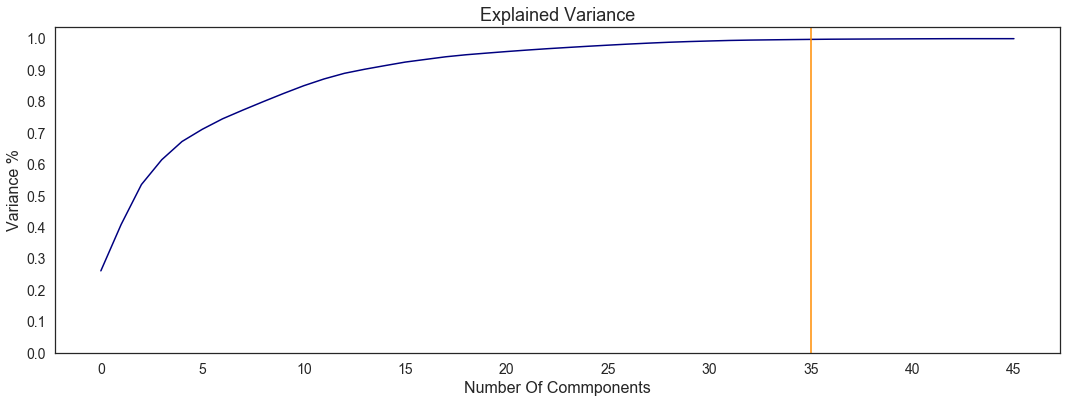

Based on the image above, we concluded that our ideal number of components is 35.

In [10]:
# Instantiating PCA
pca = PCA(n_components = 35,
          random_state = 42,
          whiten       = True)

# Fit-transforming the training data
X_train_pca = pca.fit_transform(X_train_mm)

# Fit-transforming the test data
X_test_pca  = pca.fit_transform(X_test_mm)

## Modeling

**Process**:

The data will be classified using three different types of algorithms: distance based, decision trees, and logistic regression. Each individual model (four in total) will be gridsearched to ensure that our hyperparameters have optimal values; hyperparameters are parameters that the user must set.  After each model is fit to the data and has made predictions, they will be evaluated in two ways: a confusion matrix and a standardized set of metrics.

Additionally, each model will be run on the original data and the data that has been through PCA.

**Evaluation**:

Our evaluation process has three steps: confusion matrices, metrics, and an ROC curve.

The confusion matrix will show us what kind of predictions are made, i.e. false positives and negatives.  Each confusion matrix will contain:
 
|                   | Pred. Neg.      | Pred. Pos.      |
|:------------------|:---------------:|:---------------:|
| **Actual Neg.** | True Negatives  | False Positives |
| **Actual Pos.** | False Negatives | True Positives  |

The metrics all us to evaluate the models in different ways.  Each model will be evaluated with the following:

| Metric                                     | Description                                                                       | Scale    |
|:-------------------------------------------|:----------------------------------------------------------------------------------|:--------:|
| **Recall**                                 | How many positive classes were classified correctly out of all positives          | 0 to 1   |
| **Specificity**                            | How many negative classes were classified correctly out of all negatives          | 0 to 1   |
| **AUROC**                                  | A measure of the model's ability to distinguish classes                           | 0.5 to 1 |
| **Matthews Correlation Coefficient (MCC)** | A measure of classification quality: correlation between true and prediced values | -1 to 1  |

Finally, once we have chosen a best model we will generate a ROC curve for that model.

### _k_-Neighbors Classifier

_k_-Neighbors classification is a non-parametric algorithm, i.e. it does not make any assumptions about the data.  It works based off of distance: it chooses _k_ points and classifies by choosing the majority.

#### Original Data

In [11]:
"""
# Instantiating the grid search's pipeline
knn_pipe  = Pipeline([("knn", KNeighborsClassifier(n_jobs = 4))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(knn__n_neighbors  = [7],
                 knn__weights      = ["uniform"],
                 knn__algorithm    = ["auto"])

# Setting up the gridsearch object
knn_gs    = GridSearchCV(knn_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
knn_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
knn_gs.best_params_
""";

In [12]:
# Instantiating the KNN classifier

knn = KNeighborsClassifier(n_neighbors = 7)

In [13]:
# Fitting the algorithm to our training data
knn.fit(X_train, y_train)

# Making training predictions
train_preds = knn.predict(X_train)

# Making test predictions
knn_preds   = knn.predict(X_test)

# Getting test  probabilities
knn_probas = knn.predict_proba(X_test)

In [14]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.853695
Specificity,0.476180
MCC,0.360100
AUROC,0.664938


In [15]:
# Evaluating prediction on the test data

classification_summary(y_test, knn_preds)

,Scores
Sensitivity,0.776756
Specificity,0.334106
MCC,0.122013
AUROC,0.555431


In [16]:
# Creating a confusion matrix from the test predictions

confusion_matrix_dataframe(y_test, 
                           knn_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,2594,5170
Actual μμμ,2791,9711


#### Principal Component Analysis

In [17]:
"""
# Instantiating the grid search's pipeline
knn_pipe  = Pipeline([("knn", KNeighborsClassifier(n_jobs = 6))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(knn__n_neighbors  = [7],
                 knn__weights      = ["uniform"],
                 knn__algorithm    = ["auto"])

# Setting up the gridsearch object
knn_gs    = GridSearchCV(knn_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
knn_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
knn_gs.best_params_
""";

In [18]:
# Instantiating the k neighbors algorithm
# The other parameters are their default values

knn2 = KNeighborsClassifier(n_neighbors = 7)

In [19]:
# Fitting the algorithm to our training data
knn2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = knn2.predict(X_train_pca)

# Making test predictions
knn2_preds   = knn2.predict(X_test_pca)

# Getting test  probabilities
knn2_probas = knn2.predict_proba(X_test_pca)

In [20]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.970691
Specificity,0.645487
MCC,0.678442
AUROC,0.808089


In [21]:
# Evaluating prediction on the test data

classification_summary(y_test, knn2_preds)

,Scores
Sensitivity,0.940410
Specificity,0.369655
MCC,0.393740
AUROC,0.655032


In [22]:
# Creating a confusion matrix from the test predictions

confusion_matrix_dataframe(y_test, 
                           knn2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,2870,4894
Actual μμμ,745,11757


### Random Forest Classifier

A random forest classifier is a tree-based classification method that incorporates two types of random selection: bootstrapping (random sampling of the data with replacement) and random selection of features.

#### Original Data

In [23]:
"""
# Instantiating the grid search's pipeline
rfr_pipe  = Pipeline([("rfr", RandomForestClassifier(random_state = 42,
                                                     n_jobs       = 4))])

# Setting up a hyperparameter dictionary
params    = dict(rfr__n_estimators      = [600],
                 rfr__max_depth         = [29],
                 rfr__min_samples_split = [3],
                 rfr__min_samples_leaf  = [3])

# Setting up the gridsearch object
rfr_gs    = GridSearchCV(rfr_pipe, 
                         param_grid = params,
                         cv         = 5)
                          
# Fitting the gridsearch to our training data
rfr_gs.fit(X_train, y_train);

# Printing out our best parameters
rfr_gs.best_params_
""";

In [24]:
# Instantiating the random forest classifier
# Other parameters are at their defaults

rfr = RandomForestClassifier(random_state      = 42,
                             n_jobs            = 4,
                             n_estimators      = 600,
                             max_depth         = 29,
                             min_samples_split = 3,
                             min_samples_leaf  = 3)

In [25]:
# Fitting the algorithm to our training data
rfr.fit(X_train, y_train)

# Making training predictions
train_preds = rfr.predict(X_train)

# Making test predictions
rfr_preds   = rfr.predict(X_test)

# Getting test  probabilities
rfr_probas = rfr.predict_proba(X_test)

In [26]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.992321
Specificity,0.960475
MCC,0.957960
AUROC,0.976398


In [27]:
# Evaluating prediction on the test data

classification_summary(y_test, rfr_preds)

,Scores
Sensitivity,0.901216
Specificity,0.831273
MCC,0.733854
AUROC,0.866244


In [28]:
confusion_matrix_dataframe(y_test, 
                           rfr_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,6454,1310
Actual μμμ,1235,11267


In [29]:
rfr_original_data = pd.DataFrame(rfr.feature_importances_,
                                 columns = ["RF - Original Data"])

rfr_original_data.sort_values(by = "RF - Original Data", ascending = False).head()

,RF - Original Data
5,0.135573
4,0.114321
1,0.075778
45,0.054026
6,0.041954


### Principal Component Analysis

In [30]:
"""
# Instantiating the grid search's pipeline
rfr2_pipe  = Pipeline([("rfr2", RandomForestClassifier(random_state = 42,
                                                     n_jobs       = 4))])

# Setting up a hyperparameter dictionary
params    = dict(rfr2__n_estimators      = [193],
                 rfr2__max_depth         = [22],
                 rfr2__min_samples_split = [3],
                 rfr2__min_samples_leaf  = [3])

# Setting up the gridsearch object
rfr2_gs    = GridSearchCV(rfr2_pipe, 
                         param_grid = params,
                         cv         = 5)
                          
# Fitting the gridsearch to our training data
rfr2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
rfr2_gs.best_params_
""";

In [31]:
# Instantiating the random forest classifier
# Other parameters are at their defaults

rfr2 = RandomForestClassifier(random_state      = 42,
                              n_jobs            = 4,
                              n_estimators      = 193,
                              max_depth         = 22,
                              min_samples_split = 3,
                              min_samples_leaf  = 3)

In [32]:
# Fitting the algorithm to our training data
rfr2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = rfr2.predict(X_train_pca)

# Making test predictions
rfr2_preds   = rfr2.predict(X_test_pca)

In [33]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.996641
Specificity,0.954844
MCC,0.959211
AUROC,0.975742


In [34]:
# Evaluating prediction on the test data

classification_summary(y_test, rfr2_preds)

,Scores
Sensitivity,0.857943
Specificity,0.745750
MCC,0.606755
AUROC,0.801846


In [35]:
confusion_matrix_dataframe(y_test, 
                           rfr2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,5790,1974
Actual μμμ,1776,10726


In [36]:
rfr_pca_data = pd.DataFrame(rfr2.feature_importances_,
                                 columns = ["RF - PCA"])

rfr_pca_data.sort_values(by = "RF - PCA", ascending = False).head()

,RF - PCA
2,0.124142
3,0.123003
0,0.093046
9,0.059729
5,0.057637


### SGD Logistic Regressor

The version of the logistic regression incorporates the use of stochastic gradient descent (SGD). Gradient descent is a way of minimizing a model's loss function (in this case cross-entropy) by taking "steps" to find the lowest (global) minimum. SGD is one of three main ways this is performed. As stochastic suggests, SGD logistic regression suggests a few points randomly from our data for each iteration of the mode and after each iteration the data is shuffled and resampled.

#### Original Data

In [37]:
"""
# Instantiating the grid search's pipeline
sgd_pipe = Pipeline([("sgd", SGDClassifier(random_state = 42,
                                           n_jobs       = 4))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(sgd__loss     = ["perceptron"],
                 sgd__penalty  = [None],
                 sgd__alpha    = [0.1],
                 sgd__max_iter = [1100],
                 sgd__tol      = [0.01])

# Setting up the gridsearch object
sgd_gs   = GridSearchCV(sgd_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to our training data
sgd_gs.fit(X_train, y_train);

# Printing out our best parameters
sgd_gs.best_params_
""";

In [38]:
# Instantiating the sgd logistic regression classifier
# Other parameters are at their defaults
# Probabilities will not be available for this model

sgd = SGDClassifier(random_state   = 42,
                    n_jobs         = 4,
                    loss           = "perceptron",
                    penalty        = None,
                    max_iter       = 1100,
                    tol            = 0.01)

In [39]:
# Fitting the algorithm to our training data
sgd.fit(X_train, y_train)

# Making training predictions
train_preds = sgd.predict(X_train)

# Making test predictions
sgd_preds   = sgd.predict(X_test)

In [40]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.570513
Specificity,0.791002
MCC,0.354787
AUROC,0.680757


In [41]:
# Evaluating prediction on the test data

classification_summary(y_test, sgd_preds)

,Scores
Sensitivity,0.565829
Specificity,0.778980
MCC,0.338238
AUROC,0.672405


In [42]:
confusion_matrix_dataframe(y_test, 
                           sgd_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,6048,1716
Actual μμμ,5428,7074


In [43]:
sgd_coefs = pd.DataFrame([np.exp(i) for i in sgd.coef_], index = ["Coef."]).T
sgd_coefs.sort_values(by = "Coef.", ascending = False).head()

,Coef.
29,inf
35,inf
30,inf
21,inf
22,inf


#### Principal Component Analysis

In [44]:
"""
# Instantiating the grid search's pipeline
sgd2_pipe = Pipeline([("sgd", SGDClassifier(random_state = 42,
                                           n_jobs       = 4))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(sgd2__loss           = ["log"],
                 sgd2__early_stopping = [False],
                 sgd2__penalty        = ["l2"],
                 sgd2__alpha          = [0.001],
                 sgd2__max_iter       = [5],
                 sgd2__tol            = [0.01])

# Setting up the gridsearch object
sgd2_gs   = GridSearchCV(sgd_pipe2, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
sgd2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
sgd2_gs.best_params_
""";

In [45]:
# Instantiating the SGD classifier

sgd2 = SGDClassifier(random_state   = 42,
                     n_jobs         = 4,
                     loss           = "log",
                     early_stopping = False,
                     penalty        = "l2",
                     alpha          = 0.001,
                     max_iter       = 5,
                     tol            = 0.01)

In [46]:
# Fitting the algorithm to our training data
sgd2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = sgd2.predict(X_train_pca)

# Making test predictions
sgd2_preds   = sgd2.predict(X_test_pca)

In [47]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.899767
Specificity,0.788904
MCC,0.695792
AUROC,0.844336


In [48]:
# Evaluating prediction on the test data

classification_summary(y_test, sgd2_preds)

,Scores
Sensitivity,0.846185
Specificity,0.729650
MCC,0.578417
AUROC,0.787917


In [49]:
confusion_matrix_dataframe(y_test, 
                           sgd2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,5665,2099
Actual μμμ,1923,10579


In [50]:
sgd2_coefs = pd.DataFrame([np.exp(i) for i in sgd2.coef_], index = ["Coef."]).T
sgd2_coefs.sort_values(by = "Coef.", ascending = False).head()

,Coef.
9,1.950789
15,1.565792
11,1.329708
12,1.308730
13,1.234054


### XGBoost Classifier

#### Original Data

In [51]:
"""
#Instantiating the grid search's pipeline
xgb_pipe = Pipeline([("xgb", XGBClassifier(random_state = 42,
                                           n_jobs       = 4,
                                           verbosity    = 0))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(xgb__max_depth     = [9],
                 xgb__n_estimators  = [325],
                 xgb__booster       = ["gbtree"],
                 xgb__learning_rate = [0.1],
                 xgb__gamma         = [0])

# Setting up the gridsearch object
xgb_gs   = GridSearchCV(xgb_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to our training data
xgb_gs.fit(X_train, y_train);

# Printing out our best parameters
xgb_gs.best_params_
""";

In [52]:
# Instantiating the XGBclasssifier
# These are optimal values, others are defaults

xgb = XGBClassifier(random_state  = 42,
                    n_jobs        = 4,
                    max_depth     = 9,
                    n_estimators  = 325,
                    booster       = "gbtree",
                    learning_rate = 0.1)

In [53]:
# Fitting the algorithm to our training data
xgb.fit(X_train, y_train)

# Making training predictions
train_preds = xgb.predict(X_train)

# Making test predictions
xgb_preds   = xgb.predict(X_test)

# Getting test  probabilities
xgb_probas = xgb.predict_proba(X_test)

In [54]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,1.000000
Specificity,0.999724
MCC,0.999776
AUROC,0.999862


In [55]:
# Evaluating prediction on the test data

classification_summary(y_test, xgb_preds)

,Scores
Sensitivity,0.921693
Specificity,0.842865
MCC,0.769327
AUROC,0.882279


In [56]:
confusion_matrix_dataframe(y_test, 
                           xgb_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,6544,1220
Actual μμμ,979,11523


In [57]:
# Creating a dataframe of the model's feature importances and feature names
xgb_features = pd.DataFrame([X_test.columns, xgb.feature_importances_],
                            index = ["Feature", "Importance"]).T

# Sorting by the importance value
xgb_features = xgb_features.sort_values(by = "Importance", ascending = False)

# Displaying the df
xgb_features.head()

,Feature,Importance
5,ip_sig,0.191872
19,iso,0.0780678
4,ip,0.0650457
23,iso_sum_bdt,0.0545899
0,life_time,0.0407564


#### Principal Component Analysis 

In [58]:
"""
Instantiating the grid search's pipeline
xgb_pipe = Pipeline([("xgb2", XGBClassifier(random_state = 42,
                                           n_jobs       = 4,
                                           verbosity    = 0))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params    = dict(xgb2__max_depth     = [8],
                 xgb2__n_estimators  = [350],
                 xgb2__learning_rate = [0.1],
                 xgb2__booster       = ["gbtree"],
                 xgb2__gamma         = [0])

# Setting up the gridsearch object
xgb2_gs   = GridSearchCV(xgb2_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
xgb2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
xgb2_gs.best_params_
""";

In [59]:
# Instantiating the XGBoost classifier
# Other hyperparameters are defaults

xgb2 = XGBClassifier(random_state = 42,
                     n_jobs       = 4,
                     verbosity    = 0,
                     max_depth    = 8,
                     n_estimators = 350)

In [60]:
# Fitting the algorithm to our training data
xgb2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = xgb2.predict(X_train_pca)

# Making test predictions
xgb2_preds   = xgb2.predict(X_test_pca)

In [61]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.999452
Specificity,0.994480
MCC,0.994812
AUROC,0.996966


In [62]:
# Evaluating prediction on the test data

classification_summary(y_test, xgb2_preds)

,Scores
Sensitivity,0.853543
Specificity,0.748712
MCC,0.604072
AUROC,0.801128


In [63]:
confusion_matrix_dataframe(y_test, 
                           xgb2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,5813,1951
Actual μμμ,1831,10671


### AdaBoost Classification

#### Original Data

In [64]:
"""
#Instantiating the grid search's pipeline
adc_pipe = Pipeline([("adc", AdaBoostClassifier(random_state = 42))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params   = dict(adc__n_estimators  = [225],
                adc__algorithm     = ["SAMME.R"],
                adc__learning_rate = [0.66])

# Setting up the gridsearch object
adc_gs   = GridSearchCV(adc_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to our training data
adc_gs.fit(X_train, y_train);

# Printing out our best parameters
adc_gs.best_params_
""";

In [65]:
# Instantiating the AdaBoost classifier
# All other parameters are defaults

adc = AdaBoostClassifier(random_state  = 42,
                         n_estimators  = 225,
                         learning_rate = 0.66)

In [66]:
# Fitting the algorithm to our training data
adc.fit(X_train, y_train)

# Making training predictions
train_preds = adc.predict(X_train)

# Making test predictions
adc_preds   = adc.predict(X_test)

# Getting test  probabilities
adc_probas  = adc.predict_proba(X_test)

In [67]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.913856
Specificity,0.821860
MCC,0.741637
AUROC,0.867858


In [68]:
# Evaluating prediction on the test data

classification_summary(y_test, adc_preds)

,Scores
Sensitivity,0.911374
Specificity,0.811824
MCC,0.729987
AUROC,0.861599


In [69]:
confusion_matrix_dataframe(y_test, 
                           adc_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,6303,1461
Actual μμμ,1108,11394


#### Principal Component Analysis

In [70]:
"""
#Instantiating the grid search's pipeline
adc2_pipe = Pipeline([("adc2", AdaBoostClassifier(random_state = 42))])

# Setting up a hyperparameter dictionary
# These are the optimal values
params   = dict(adc2__n_estimators  = [500],
                adc2__algorithm     = ["SAMME.R"],
                adc2__learning_rate = [0.4])

# Setting up the gridsearch object
adc2_gs   = GridSearchCV(adc2_pipe, 
                         param_grid = params,
                         cv         = 5)

# Fitting the gridsearch to our training data
adc2_gs.fit(X_train_pca, y_train);

# Printing out our best parameters
adc2_gs.best_params_
""";

In [71]:
# Instantiating the AdaBoost classifier
# All other parameters are defaults

adc2 = AdaBoostClassifier(random_state  = 42,
                          n_estimators  = 500,
                          learning_rate = 0.4)

In [72]:
# Fitting the algorithm to our training data
adc2.fit(X_train_pca, y_train)

# Making training predictions
train_preds = adc2.predict(X_train_pca)

# Making test predictions
adc2_preds   = adc2.predict(X_test_pca)

# Getting test  probabilities
adc2_probas  = adc2.predict_proba(X_test_pca)

In [73]:
# Evaluating prediction on the training data

classification_summary(y_train, train_preds)

,Scores
Sensitivity,0.916701
Specificity,0.801380
MCC,0.727983
AUROC,0.859041


In [74]:
# Evaluating prediction on the test data

classification_summary(y_test, adc2_preds)

,Scores
Sensitivity,0.855623
Specificity,0.721664
MCC,0.582757
AUROC,0.788644


In [75]:
confusion_matrix_dataframe(y_test, 
                           adc2_preds,
                           columns = ["Predicted τ", "Predicted μμμ"],
                           index   = ["Actual τ", "Actual μμμ"])

,Predicted τ,Predicted μμμ
Actual τ,5603,2161
Actual μμμ,1805,10697


## Evaluation

In [76]:
# This allows us to view the two metric dataframes side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

### Predictions Dataframe

#### Original Data

In [77]:
org_preds = pd.DataFrame([np.array(y_test), knn_preds, rfr_preds, 
                          sgd_preds, xgb_preds, adc_preds],
                         index = ["True", "KNN", "RFR", "SGD", 
                                  "XGB", "ADC"]).T

#### Principal Component Analysis

In [78]:
pca_preds = pd.DataFrame([np.array(y_test), knn_preds, rfr_preds, 
                          sgd_preds, xgb_preds, adc_preds],
                         index = ["True", "KNN", "RFR", "SGD", 
                                  "XGB", "ADC"]).T

### Metric Scores Dataframe

The code is from user `ntg` on StackOverflow.  [Here](https://stackoverflow.com/a/44923103) is the source.

#### Original Data

In [79]:
org_accuracy     = [accuracy_score(y_test, knn_preds),
                   accuracy_score(y_test, rfr_preds),
                   accuracy_score(y_test, sgd_preds),
                   accuracy_score(y_test, xgb_preds),
                   accuracy_score(y_test, adc_preds)]


org_recall      = [recall_score(y_test, knn_preds),
                   recall_score(y_test, rfr_preds),
                   recall_score(y_test, sgd_preds),
                   recall_score(y_test, xgb_preds),
                   recall_score(y_test, adc_preds)]

org_specificity = [specificity(y_test, knn_preds),
                   specificity(y_test, rfr_preds),
                   specificity(y_test, sgd_preds),
                   specificity(y_test, xgb_preds),
                   specificity(y_test, adc_preds)]

org_mcc         = [matthews_corrcoef(y_test, knn_preds),
                   matthews_corrcoef(y_test, rfr_preds),
                   matthews_corrcoef(y_test, sgd_preds),
                   matthews_corrcoef(y_test, xgb_preds),
                   matthews_corrcoef(y_test, adc_preds)]

org_auroc       = [roc_auc_score(y_test, knn_preds),
                   roc_auc_score(y_test, rfr_preds),
                   roc_auc_score(y_test, sgd_preds),
                   roc_auc_score(y_test, xgb_preds),
                   roc_auc_score(y_test, adc_preds)]

#### Principal Component Analysis

In [80]:
pca_accuracy    = [accuracy_score(y_test, knn2_preds),
                   accuracy_score(y_test, rfr2_preds),
                   accuracy_score(y_test, sgd2_preds),
                   accuracy_score(y_test, xgb2_preds),
                   accuracy_score(y_test, adc2_preds)]


pca_recall      = [recall_score(y_test, knn2_preds),
                   recall_score(y_test, rfr2_preds),
                   recall_score(y_test, sgd2_preds),
                   recall_score(y_test, xgb2_preds),
                   recall_score(y_test, adc2_preds)]

pca_specificity = [specificity(y_test, knn2_preds),
                   specificity(y_test, rfr2_preds),
                   specificity(y_test, sgd2_preds),
                   specificity(y_test, xgb2_preds),
                   specificity(y_test, adc2_preds)]

pca_mcc         = [matthews_corrcoef(y_test, knn2_preds),
                   matthews_corrcoef(y_test, rfr2_preds),
                   matthews_corrcoef(y_test, sgd2_preds),
                   matthews_corrcoef(y_test, xgb2_preds),
                   matthews_corrcoef(y_test, adc2_preds)]

pca_auroc       = [roc_auc_score(y_test, knn2_preds),
                   roc_auc_score(y_test, rfr2_preds),
                   roc_auc_score(y_test, sgd2_preds),
                   roc_auc_score(y_test, xgb2_preds),
                   roc_auc_score(y_test, adc2_preds)]

In [81]:
# Converting the lists into dataframes

# A dataframe for the original data
org_scores = pd.DataFrame(data    = [org_accuracy, org_recall, org_specificity, 
                                     org_auroc, org_mcc],
                          columns = ["KNN", "RFR", "SGD", "XGB", "ADA"],
                          index   = ["Accuracy", "Recall", "Specificity", 
                                     "AUROC", "MCC"])

# A dataframe for the principal component analysis
pca_scores = pd.DataFrame(data    = [pca_accuracy, pca_recall, pca_specificity, 
                                     pca_auroc, pca_mcc],
                          columns = ["KNN", "RFR", "SGD", "XGB", "ADA"],
                          index   = ["Accuracy", "Recall", "Specificity", 
                                     "AUROC", "MCC"])

### Metric Scores Comparison

#### Original Data

In [82]:
org_scores

,KNN,RFR,SGD,XGB,ADA
Accuracy,0.607175,0.874420,0.647488,0.891493,0.873236
Recall,0.776756,0.901216,0.565829,0.921693,0.911374
Specificity,0.334106,0.831273,0.778980,0.842865,0.811824
AUROC,0.555431,0.866244,0.672405,0.882279,0.861599
MCC,0.122013,0.733854,0.338238,0.769327,0.729987


#### PCA Data

In [83]:
pca_scores

,KNN,RFR,SGD,XGB,ADA
Accuracy,0.721751,0.814961,0.801540,0.813382,0.804303
Recall,0.940410,0.857943,0.846185,0.853543,0.855623
Specificity,0.369655,0.745750,0.729650,0.748712,0.721664
AUROC,0.655032,0.801846,0.787917,0.801128,0.788644
MCC,0.393740,0.606755,0.578417,0.604072,0.582757


### Best Model Selection

In choosing our best model, we compared the best performing model from each data set.  In this case, the best model overall was the XGBoost Classifier with original data: it has the best metric scores, most importantly it has the highest AUROC score.  We considered our AUROC scores to be most informative because it tells us how distinct our classes are: a score of 0.8822 indicates our classes are significantly distinct.

### Best Model Metrics

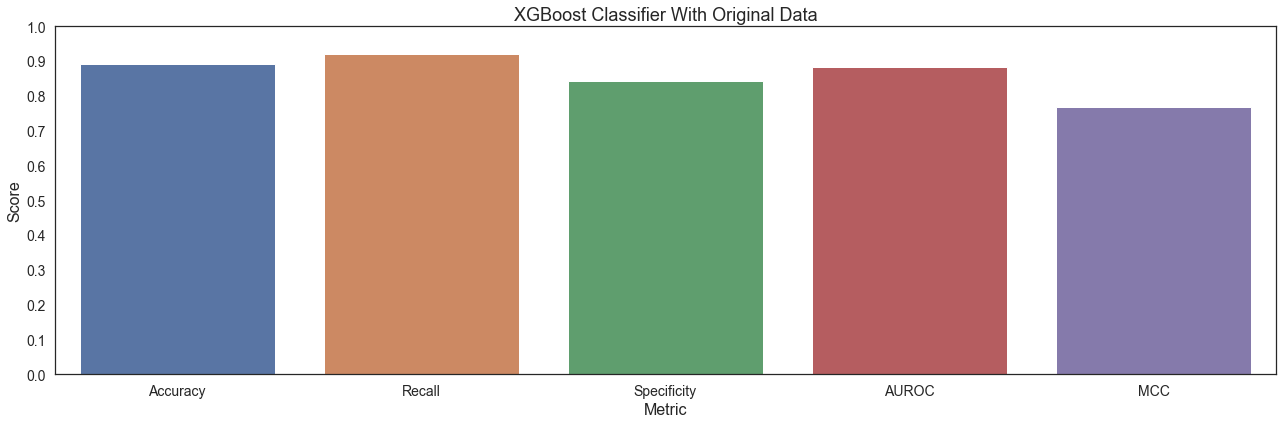

In [84]:
graphs.barplot(df     = org_scores,
               x      = org_scores.index,
               y      = "XGB",
               title  = "XGBoost Classifier With Original Data",
               label  = "Metric",
               ylabel = "Score",
               ticks  = np.arange(0,1.1,0.1),
               dim    = (18,6))

Our accuracy is significantly higher than our baseline of ~62%, which is good.  Our recall and specificity are good, but our specificity is lower because there was less of our negative class in the data.

Our other two metrics are strong: the AUROC looks at how distinct our classes are while the MCC is essentially a correlation between the true and predicted values.  They tell us that our classes are distinct and our predictions are very similar to the true values.

#### Best Model Curve

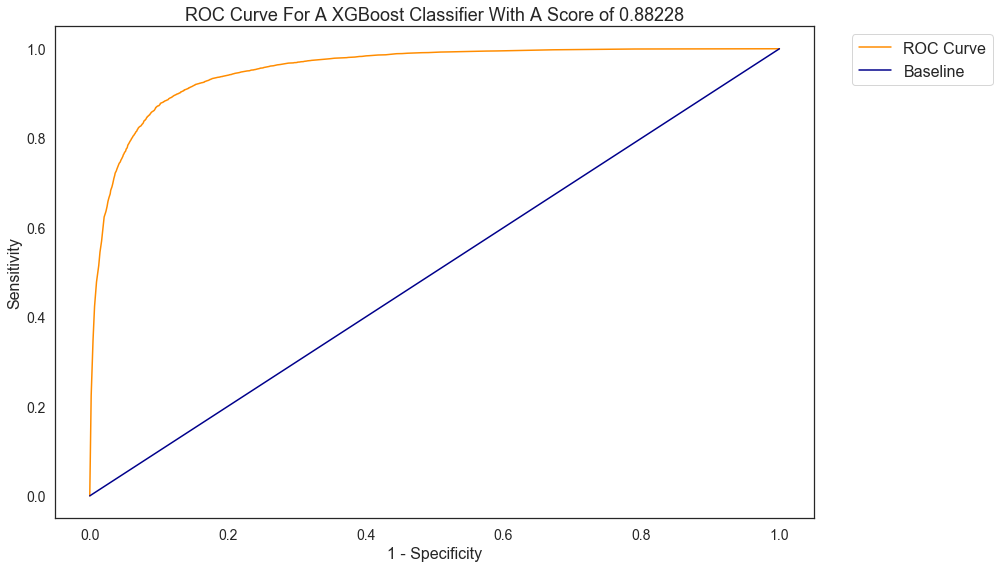

In [85]:
roc_curve(model_prob  = xgb,
          X_test      = X_test,
          y_test      = y_test,
          y_predicted = xgb_preds,
          title       = "ROC Curve For A XGBoost Classifier",
          dim         = (14,8))

Ideally the curve would be a 90° angle, but our curve is not bad: it indicates strong model performance but it could be better.

[Top](#Table-Of-Contents)